# Topic Modelling

<br>

## BERTopic Modelling Breakdown

- The BERTopic pipeline will be broken down in this notebook.

In [1]:
# Built-in library
import re
import json
from typing import Any, Optional, TypeAlias, Union
import logging
import warnings

# Standard imports
import numpy as np
from pprint import pprint
import pandas as pd
import polars as pl
from rich import print
import torch

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

### Load Data

In [2]:
from datasets import Dataset, load_dataset

path: str = "jamescalam/reddit-topics"
split: str = "train"

data: Dataset = load_dataset(path=path, split=split)
data

Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc'],
    num_rows: 3791
})

In [3]:
print(data[:2])

{
    'sub': ['investing', 'investing'],
    'title': [
        "Followup- Here are the results so far from my algo's price calculations on the symbols you gave me:",
        'This 2 hr Mohnish Pabrai lecture is better than 90% of my Ivy League Investing Classes'
    ],
    'selftext': [
        "Please don't put any weight on these!  Its just for fun.  I made this algo myself..I don't know what I'm 
doing... its far more complicated than need be, and I don't even know what its doing anymore.\n\nNow I'm just 
testing it for the first time...and having some fun.\n\n|*Asset*|*Actual Price*|*Calculated Price*|*% 
Change*|\n|:-|:-|:-|:-|\n|FRLN|0.7522|0.114058535|\\-85%|\n|HYMC|1.43|0.921447084|\\-36%|\n|SQQQ|46.56|35.08529881|
\\-25%|\n|KOLD|8.78|7.087276735|\\-19%|\n|MOS|65.4|55.48180539|\\-15%|\n|UI|277.02|245.3351418|\\-11%|\n|AAL|19.14|
17.00989343|\\-11%|\n|TGT|232.7|210.6066256|\\-9%|\n|FLMN|6.86|6.398027457|\\-7%|\n|REGN|671.33|627.7051901|\\-6%|\
n|MSFT|285.65|268.8981373|\\-6%|\n|CC|32.64|31.09223336|\\-5%|\n|BHP|68|64.93559832|\\-5%|\n|KMB|140.48|135.0943617
|\\-4%|\n|ARCC|20.85|20.08539081|\\-4%|\n|PFE|49.86|48.10944975|\\-4%|\n|MAS|54.7|52.88982538|\\-3%|\n|GGB|5.63|5.4
50538112|\\-3%|\n|V|216|209.8209104|\\-3%|\n|TWTR|48.79|47.50760913|\\-3%|\n|TSLA|896|875.6372586|\\-2%|\n|STAG|39.
71|38.80885253|\\-2%|\n|ITOT|93.92|93.08233041|\\-1%|\n|GOOG|2326.92|2307.16525|\\-1%|\n|ROK|256.79|255.0798264|\\-
1%|\n|RDBX|3.4|3.382586899|\\-1%|\n|NOK|5.08|5.06265949|0%|\n|AAPL|158.77|158.3036962|0%|\n|BLL|81.01|81.36138508|0
%|\n|HI|40.74|41.39205932|2%|\n|ASO|37.51|38.27378177|2%|\n|BAC|36.5|37.39420669|2%|\n|MU|67.3|69.13824116|3%|\n|CS
CO|49.6|50.97448964|3%|\n|SCHY|24.39|25.14476674|3%|\n|AMD|86.3|89.50602306|4%|\n|HASI|40.56|42.43610909|5%|\n|TSM|
91.4|95.7883795|5%|\n|ADBE|403.27|422.9537504|5%|\n|ZIM|57.5|60.36086427|5%|\n|INTC|45.6|48.12631788|6%|\n|INTC|45.
6|48.12631788|6%|\n|JPM|122|128.921095|6%|\n|VZ|48.68|51.45133178|6%|\n|NET|92.87|98.281279|6%|\n|CBL|28|29.6949975
9|6%|\n|WBA|44.25|47.66109726|8%|\n|CELH|54|58.17653303|8%|\n|MMM|144.21|155.6670324|8%|\n|ATER|5.2|5.657450001|9%|
\n|SBUX|74.88|81.48248541|9%|\n|LUMN|10.5|11.48311605|9%|\n|HBI|13.7|15.00536269|10%|\n|DB|10.24|11.23550725|10%|\n
|FB|207.09|228.4724841|10%|\n|UBER|31.1999|34.49288882|11%|\n|ILMN|296.184|327.545313|11%|\n|GM|38.91|43.06569438|1
1%|\n|PKE|11.79|13.11316978|11%|\n|DIS|116.7|130.1778382|12%|\n|NVDA|188.3|211.9036967|13%|\n|IVT|30.57|34.41726576
|13%|\n|FL|29.6|33.67027133|14%|\n|UMC|7.85|8.940326714|14%|\n|OPY|32.15|36.90363169|15%|\n|AGNC|11.22|12.89140747|
15%|\n|GME|129.84|150.3780619|16%|\n|ETWO|7.5|8.799146294|17%|\n|T|19.13|22.65981112|18%|\n|CNF|3.1|3.682833415|19%
|\n|BGFV|15|17.83488333|19%|\n|RCUS|24.98|30.10472664|21%|\n|BBBY|14.85|18.05023732|22%|\n|SNDL|0.5325|0.649718687|
22%|\n|LEU|27.89|34.04760548|22%|\n|DOCS|44|53.72307412|22%|\n|LAKE|15.89|19.43861225|22%|\n|ARKQ|56.9|69.63677574|
22%|\n|WBD|19.22|23.99154274|25%|\n|NERD|18.28|22.93968386|25%|\n|PAYA|5.5|6.976766697|27%|\n|CMPR|56.73|72.2191149
6|27%|\n|HIMS|4.65|5.925673999|27%|\n|BABA|89.47|114.2001117|28%|\n|DOCU|83.43|107.1609693|28%|\n|PYPL|85.45|110.68
18926|30%|\n|XM|19.3|26.15302849|36%|\n|SE|83.99|115.4268668|37%|\n|PLTR|10.8|14.9322183|38%|\n|ARKK|49|68.1552281|
39%|\n|XSPA|0.99|1.392123053|41%|\n|ARKW|65.84|92.71455701|41%|\n|TLRY|5.09|7.171070224|41%|\n|NSTG|19.6|28.0282193
9|43%|\n|CCM|1.5201|2.187256252|44%|\n|BB|5.68|8.224211744|45%|\n|UWMC|3.55|5.144659787|45%|\n|CRSR|15.14|22.053574
14|46%|\n|ARKF|22.1|32.23507113|46%|\n|DDD|12.4|18.12539306|46%|\n|ARKG|35.73|53.0237355|48%|\n|AMC|15.92|23.648032
53|49%|\n|NVAX|46.74|69.67407471|49%|\n|PINS|20.18|30.31352909|50%|\n|MTTR|5.67|8.575453621|51%|\n|ACB|2.96|4.49090
6924|52%|\n|TDOC|35.37|54.23178646|53%|\n|HOOD|9.83|15.1202152|54%|\n|ASAN|28.2|43.7092835|55%|\n|BBIG|2.29|3.69436
9895|61%|\n|RBLX|31.2|50.35916471|61%|\n|KSCP|4.18|6.775821994|62%|\n|STEM|7.77|12.75783628|64%|\n|SAVA|21.18|35.06
261643|66%|\n|YCBD

In [4]:
data.num_rows

3791

In [5]:
# Remove data points with small text size
data = data.filter(lambda x: len(x.get("selftext")) > 30)
data.num_rows

3118

In [6]:
# Shuffle the data
data = data.shuffle(seed=123)

data

Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc'],
    num_rows: 3118
})

## BERTopic Topic Modelling Pipeline


[![Screenshot-2023-12-03-at-6-46-46-PM.png](https://i.postimg.cc/jjH8SThy/Screenshot-2023-12-03-at-6-46-46-PM.png)](https://postimg.cc/mcr3m0Jr)

<br>

### [Embeddings Models](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html)

- BERTopic starts with transforming our input documents into numerical representations. 

- By default, sentence-transformers ("all-MiniLM-L6-v2") is used as it is quite capable of capturing the semantic similarity between documents.

- However, there is not one perfect embedding model and you might want to be using something entirely different for your use case.

In [7]:
# We'll use sentence -transformers
from sentence_transformers import SentenceTransformer

encoder_checkpoint: str = "all-MiniLM-L6-v2"
encoder: SentenceTransformer = SentenceTransformer(encoder_checkpoint)
encoder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [8]:
# Embed the data in batches
# The cell took ~6m 19s
from tqdm.auto import tqdm


N: int = data.num_rows
batch_size: int = 24
vectors: np.ndarray = np.zeros(shape=(N, encoder.get_sentence_embedding_dimension()))

for idx in tqdm(range(0, N, batch_size)):
    stop_idx = idx + batch_size
    batch_data: Dataset = data["selftext"][idx:stop_idx]
    emb: list[float] = encoder.encode(sentences=batch_data)
    vectors[idx:stop_idx, :] = emb


vectors.shape

  0%|          | 0/130 [00:00<?, ?it/s]

(3118, 384)

<br>

### [Dimensionality Reduction](https://maartengr.github.io/BERTopic/getting_started/dim_reduction/dim_reduction.html)

- UMAP

In [9]:
# Sub-reddit
list(set(data["sub"]))

['LanguageTechnology', 'pytorch', 'investing', 'Python']

In [20]:
c_list: list[str] = ["#FAFF00", "#1C17FF", "#738FAB", "#8CF1FF"]
uniq_sub_reddit: list[str] = list(set(data["sub"]))
c_map: dict[str, Any] = dict(zip(uniq_sub_reddit, c_list))
sub_reddit: list[str] = data["sub"]

print(f"sub_reddit: {sub_reddit[:5]}")
print(f"c_map: {c_map}")

sub_reddit: ['investing', 'pytorch', 'LanguageTechnology', 'pytorch', 'pytorch']

c_map: {'LanguageTechnology': '#FAFF00', 'pytorch': '#1C17FF', 'investing': '#738FAB', 'Python': '#8CF1FF'}

In [21]:
colored_sub_reddit: list[str] = [c_map.get(c) for c in sub_reddit]

colored_sub_reddit[:2]

['#738FAB', '#1C17FF']

In [24]:
len(colored_sub_reddit[:N])

3118

  0%|          | 0/9 [00:00<?, ?it/s]

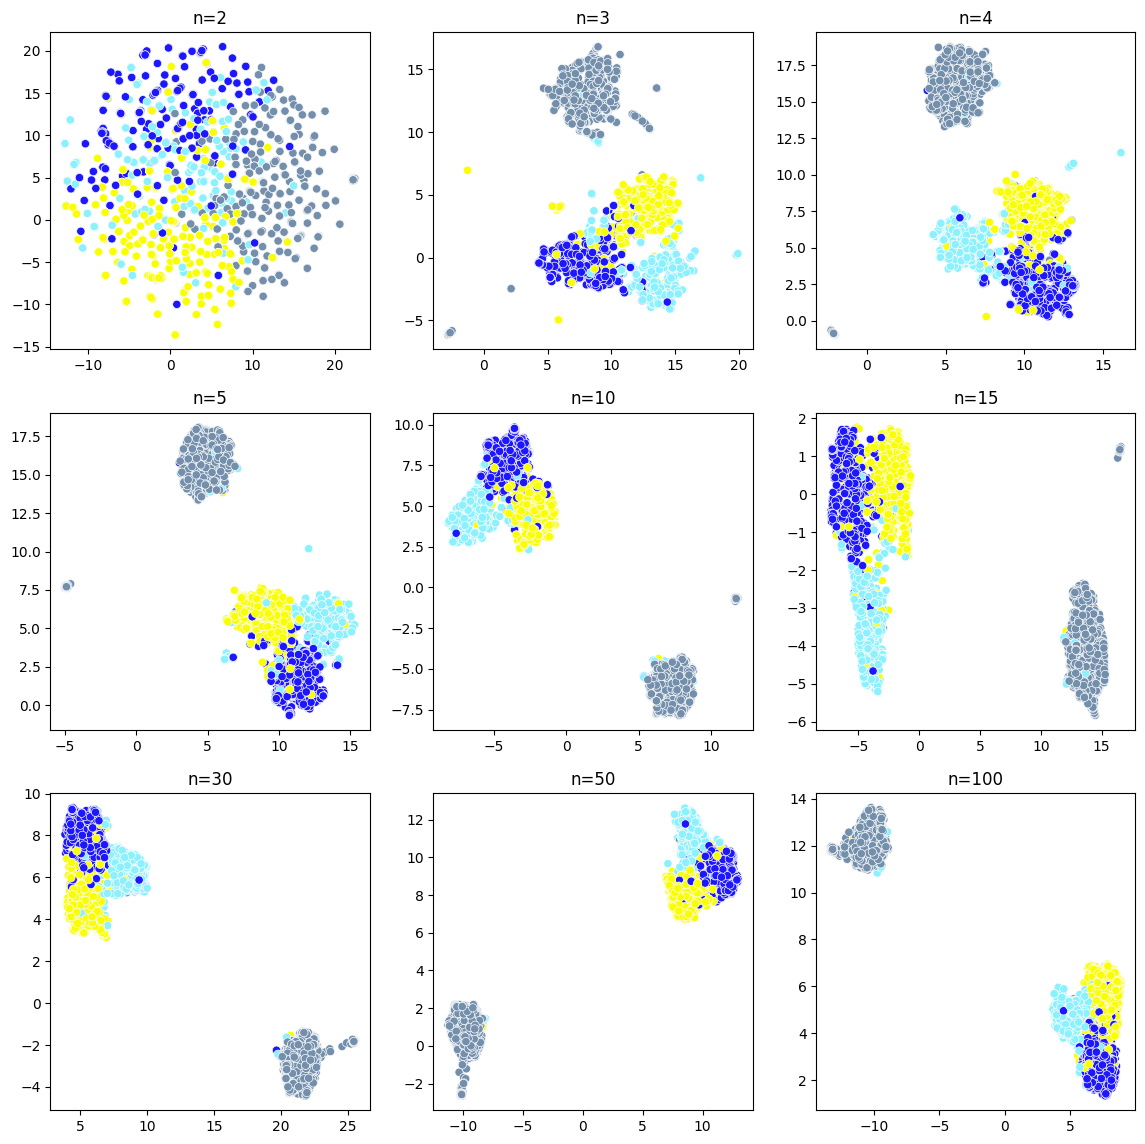

In [27]:
# It took ~2m 7s

import umap
import seaborn as sns


fig, ax = plt.subplots(3, 3, figsize=(14, 14))
nearest_neighbors: list[int] = [2, 3, 4, 5, 10, 15, 30, 50, 100]
i, j = [0, 0]

for n_neighbor in tqdm(nearest_neighbors):
    fit = umap.UMAP(n_neighbors=n_neighbor)
    u = fit.fit_transform(vectors)
    sns.scatterplot(x=u[:, 0], y=u[:, 1], c=colored_sub_reddit, ax=ax[j, i])
    ax[j, i].set_title(f"n={n_neighbor}")
    i += 1
    if i >= 3:  # Reset i and increment j when i exceeds the number of columns (3)
        i = 0
        j += 1

plt.show()

### Comment

- From the visualization above, the model (dimensionality reduction) performs best when `3 <= n_neighbors <= 5`.
- I'll use `n_neighbors=3` and `min_dist=0.05`

In [38]:
import plotly.express as px


palette: list[str] = ["#1c17ff", "#faff00", "#8cf1ff", "#738FAB", "#030080", "#738fab"]
fit = umap.UMAP(
    n_neighbors=4,
    n_components=3,  # N dims
    min_dist=0.05,
)
u = fit.fit_transform(vectors)

fig = px.scatter_3d(
    x=u[:, 0],
    y=u[:, 1],
    z=u[:, 2],
    color=data["sub"],
    custom_data=[data["sub"], data["title"]],
    color_discrete_sequence=palette,
)
fig.update_traces(
    hovertemplate="\n".join(
        [
            "sub: %{customdata[1]}",
            "title: %{customdata[0]}",
        ]
    )
)

In [39]:
fig.write_html("umap-topics-3d-color.html", include_plotlyjs="cdn", full_html=False)

In [33]:
u[:, 1]

array([16.278656 ,  4.1634793,  6.636984 , ...,  7.2242165,  5.0952263,
        6.689543 ], dtype=float32)